In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import numpy as np
from IPython import display
import pandas as pd
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import torch.nn.functional as F
import random
import librosa
import librosa.display
import sklearn

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#dataset processing and splitting out African accents as validation set IMBALANCED TRAINING AND VALIDATION (47-53 Real to Fake Training and 48-52 Real to Fake Validation)
dfTraining=pd.read_csv('/code/dataset/FakeAVCeleb/non_afr_df_training.csv')
dfValidation=pd.read_csv('/code/dataset/FakeAVCeleb/afr_df_validation.csv')
dfTraining=dfTraining[['source','wavLocation','Audio_Label']]
dfValidation=dfValidation[['source','wavLocation','Audio_Label']]
labelsTrain=dfTraining['Audio_Label']
labelsVal=dfValidation['Audio_Label']

In [ ]:
#dataset processing and splitting unique ID check
#dfTraining=pd.read_csv('/code/dataset/FakeAVCeleb/training_set_balance.csv')
#dfValidation=pd.read_csv('/code/dataset/FakeAVCeleb/validation_set_balance.csv')
#dfTraining=dfTraining.drop(columns=['Unnamed: 0','source'],axis=1)
#dfValidation=dfValidation.drop(columns=['Unnamed: 0','source'],axis=1)
#labelsTrain=dfTraining['Audio_Label']
#labelsVal=dfValidation['Audio_Label']

In [4]:
#####training data augmentations

##1 time and frequency masking
def spectro_augment(spec,max_mask_pct=.1,n_freq_masks=1,n_time_masks=1):
    _,n_mels,n_steps=spec.shape
    
    mask_value=spec.mean()
    aug_spec=spec
    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = T.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = T.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

####2 shift time per each (not implemented)
def time_shift(aud, shift_limit):
  sig,sr = aud
  _, sig_len = sig.shape
  shift_amt = int(random.random() * shift_limit * sig_len)
  return (sig.roll(shift_amt), sr)
  





In [5]:
#training data prep
#create tensor of wav form, and its sample rate



dfTensor=[]
#melspectrogram

n_fft = 1024
n_mfcc=64
win_length = None
hop_length = 512
n_mels = 64 #downsample from 128 to something lower
for i in range(0,len(dfTraining)):
    audioPath=dfTraining['wavLocation'][i]
    waveform, sample_rate = torchaudio.load(audioPath)
    #shift_lim=.5
    #shiftedWav=time_shift(torchaudio.load(audioPath),shift_lim)
    #
    mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

    
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm='slaney',
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )

    #melspec = mel_spectrogram(waveform)
    melspec=mel_spectrogram(waveform)
    aug_mel_spec=spectro_augment(melspec,max_mask_pct=0.1, n_freq_masks=1, n_time_masks=2)#aug 2-change mel spectrogram,check for random
    mfcc=T.MFCC(sample_rate)
    dfTensor+=[aug_mel_spec]
#create tensor of wav form, and its sample rate
train_data=[]
for i in range(0,len(dfTraining)):
    train_data.append([dfTensor[i],labelsTrain[i]])

#padding to create equal length Tensors
target_len = 400 #make samples smaller
train_data_pad=[]
for i in range(0,len(train_data)):
    x=train_data[i][0]
    x = F.pad(x, (target_len - x.size(2), 0))
    train_data_pad.append([x,labelsTrain[i]])


trainloader = torch.utils.data.DataLoader(train_data_pad, shuffle=True, batch_size=100)
i1, l1 = next(iter(trainloader))
print(i1.shape)

/usr/local/lib/python3.9/dist-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([100, 2, 64, 400])


In [6]:
#validation data prep
#create tensor of wav form, and its sample rate



dfTensor=[]
#melspectrogram

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 64#change from 128
for i in range(0,len(dfValidation)):
    audioPath=dfValidation['wavLocation'][i]
    waveform, sample_rate = torchaudio.load(audioPath)


    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm='slaney',
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )

    melspec = mel_spectrogram(waveform)
    dfTensor+=[melspec]
#create tensor of wav form, and its sample rate
validation_data=[]
for i in range(0,len(dfValidation)):
    validation_data.append([dfTensor[i],labelsVal[i]])

#padding to create equal length Tensors
target_len = 400
validation_data_pad=[]
for i in range(0,len(validation_data)):
    x=validation_data[i][0]
    x = F.pad(x, (target_len - x.size(2), 0))
    validation_data_pad.append([x,labelsVal[i]])


validationloader = torch.utils.data.DataLoader(validation_data_pad, shuffle=True, batch_size=100)
i2, l2 = next(iter(validationloader))
print(i2.shape)

torch.Size([100, 2, 64, 400])


In [35]:
import torch.nn.functional as F
from torch.nn import init

# ----------------------------
# Audio Classification Model   ((((((((((original layer size ))))))))))
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=2)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [17]:
import torch.nn.functional as F
from torch.nn import init

# ----------------------------
# Audio Classification Model   ((((((((((reduced layers  ))))))))))
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []
        #define dropout proportion
        self.dropout= nn.Dropout(.25)
        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]
        
        # fourth Convolution Block remove this block
        #self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        #self.relu4 = nn.ReLU()
        #self.bn4 = nn.BatchNorm2d(64)
        #init.kaiming_normal_(self.conv4.weight, a=0.1)
        #self.conv4.bias.data.zero_()
        #conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=32, out_features=2)
        #self.dropout=nn.Dropout(p=.8)
        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
       

 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)
        

        # Adaptive pool and flatten for input to linear layer
        
        x = self.ap(x)
        x = x.view(x.shape[0], -1)  
        # Linear layer
        #x=self.dropout(x)
        x = self.lin(x)
        
        # Final output
        
        return x

# Create the model and put it on thev GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

Epoch: 0, Loss: 0.69, Accuracy: 0.49
Epoch: 1, Loss: 0.65, Accuracy: 0.62
Epoch: 2, Loss: 0.63, Accuracy: 0.65
Epoch: 3, Loss: 0.62, Accuracy: 0.67
Epoch: 4, Loss: 0.60, Accuracy: 0.69
Epoch: 5, Loss: 0.58, Accuracy: 0.71
Epoch: 6, Loss: 0.55, Accuracy: 0.74
Epoch: 7, Loss: 0.50, Accuracy: 0.77
Epoch: 8, Loss: 0.46, Accuracy: 0.80
Epoch: 9, Loss: 0.42, Accuracy: 0.82
Epoch: 10, Loss: 0.40, Accuracy: 0.83
Epoch: 11, Loss: 0.37, Accuracy: 0.85
Epoch: 12, Loss: 0.34, Accuracy: 0.86
Epoch: 13, Loss: 0.31, Accuracy: 0.88
Epoch: 14, Loss: 0.29, Accuracy: 0.89
Epoch: 15, Loss: 0.27, Accuracy: 0.90
Epoch: 16, Loss: 0.25, Accuracy: 0.91
Epoch: 17, Loss: 0.23, Accuracy: 0.91
Epoch: 18, Loss: 0.23, Accuracy: 0.91
Epoch: 19, Loss: 0.21, Accuracy: 0.92
Epoch: 20, Loss: 0.21, Accuracy: 0.92
Epoch: 21, Loss: 0.19, Accuracy: 0.93
Epoch: 22, Loss: 0.17, Accuracy: 0.94
Epoch: 23, Loss: 0.17, Accuracy: 0.94
Epoch: 24, Loss: 0.15, Accuracy: 0.95
Epoch: 25, Loss: 0.15, Accuracy: 0.94
Epoch: 26, Loss: 0.15,

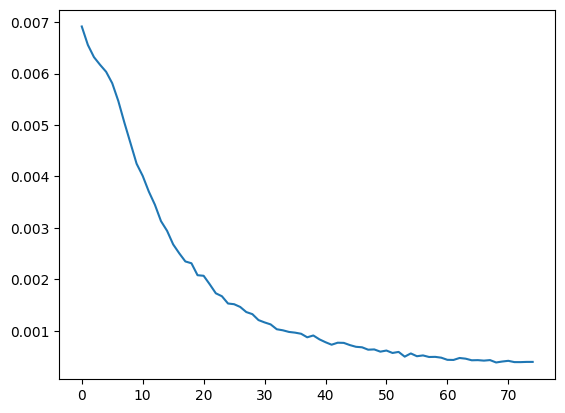

In [37]:
# ----------------------------
# Training Loop  ((((( ))))))
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
  loss_values=[]
  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(trainloader):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s
        

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
      
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()
        
        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
       
      
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    loss_values.append(running_loss/len(dfTraining))
  print('Finished Training')
  plt.plot(loss_values)  
 
num_epochs=75
training(myModel, trainloader, num_epochs)

Epoch: 0, Training Loss: 0.68, Accuracy: 0.51
Epoch: 0,Validation Loss: 0.66, Validation Accuracy: 0.65
Epoch: 1, Training Loss: 0.66, Accuracy: 0.63
Epoch: 1,Validation Loss: 0.61, Validation Accuracy: 0.72
Epoch: 2, Training Loss: 0.64, Accuracy: 0.64
Epoch: 2,Validation Loss: 0.60, Validation Accuracy: 0.76
Epoch: 3, Training Loss: 0.62, Accuracy: 0.66
Epoch: 3,Validation Loss: 0.58, Validation Accuracy: 0.78
Epoch: 4, Training Loss: 0.61, Accuracy: 0.68
Epoch: 4,Validation Loss: 0.58, Validation Accuracy: 0.78
Epoch: 5, Training Loss: 0.59, Accuracy: 0.71
Epoch: 5,Validation Loss: 0.55, Validation Accuracy: 0.76
Epoch: 6, Training Loss: 0.56, Accuracy: 0.74
Epoch: 6,Validation Loss: 0.50, Validation Accuracy: 0.78
Epoch: 7, Training Loss: 0.53, Accuracy: 0.76
Epoch: 7,Validation Loss: 0.48, Validation Accuracy: 0.80
Epoch: 8, Training Loss: 0.49, Accuracy: 0.79
Epoch: 8,Validation Loss: 0.44, Validation Accuracy: 0.82
Epoch: 9, Training Loss: 0.45, Accuracy: 0.81
Epoch: 9,Validatio

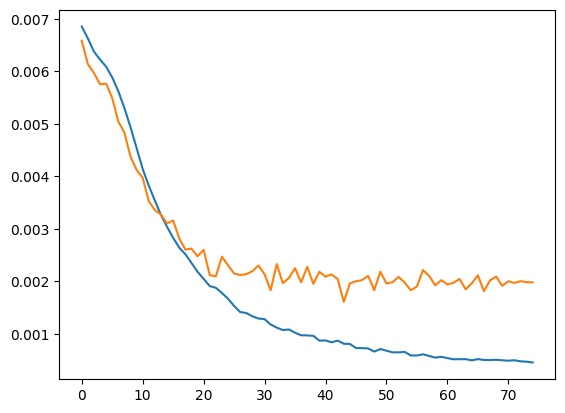

In [18]:
# ----------------------------
# Training Loop and Validation Loop
# ----------------------------
def training_validation(model, train,val, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
  loss_values_train=[]
  loss_values_val=[]
  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss_train = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
  
    for i, data in enumerate(trainloader):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s
        # Zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss_train = criterion(outputs, labels)
        loss_train.backward()
        optimizer.step()
        scheduler.step()
        # Keep stats for Loss and Accuracy
        running_loss_train += loss_train.item()
        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    ####validation loop######
    running_loss_val=0
    correct_prediction_val = 0
    total_prediction_val = 0
  # Disable gradient updates
    with torch.no_grad():
      for i,data in enumerate(validationloader):
      # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)
      
      
      # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
        outputs = model(inputs)

      #iterate losses
        temp_loss_val=criterion(outputs,labels)
        running_loss_val+=temp_loss_val.item()
      # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
        correct_prediction_val += (prediction == labels).sum().item()
        total_prediction_val += prediction.shape[0]
    acc = correct_prediction_val/total_prediction_val
    #(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

    # Print stats at the end of the epoch
    num_batches_train = len(train)
    num_batches_val =len(val)
    avg_loss_train = running_loss_train / num_batches_train
    avg_loss_val=running_loss_val/num_batches_val
    acc_train = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Training Loss: {avg_loss_train:.2f}, Accuracy: {acc_train:.2f}')
    print(f'Epoch: {epoch},Validation Loss: {avg_loss_val:.2f}, Validation Accuracy: {acc:.2f}')
    loss_values_train.append(running_loss_train/len(dfTraining))
    loss_values_val.append(running_loss_val/len(dfValidation))
  print('Finished Training')
  plt.plot(loss_values_train)
  plt.plot(loss_values_val)

 
num_epochs=75
training_validation(myModel, trainloader,validationloader, num_epochs)

In [38]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, validationloader):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in validationloader:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, validationloader)

Accuracy: 0.92, Total items: 4097


Accuracy: 0.91, Total items: 4097
f1:0.9163383545770568
f2:0.9200483991064778


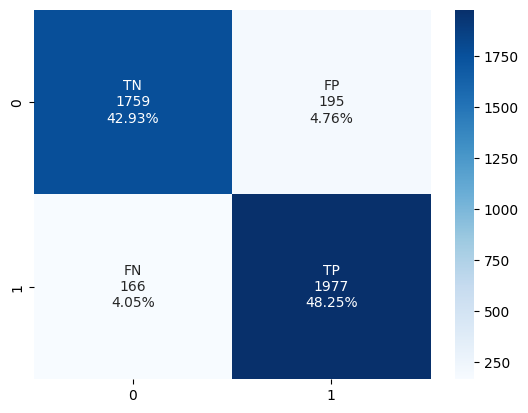

In [13]:
import seaborn as sn
from sklearn.metrics import confusion_matrix,f1_score, fbeta_score

# ----------------------------
# Inference
# ----------------------------
def inference (model, validationloader):
  correct_prediction = 0
  total_prediction = 0
  target=[]
  pred=[]
  threshold=.5


  # Disable gradient updates
  with torch.no_grad():
    for data in validationloader:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions and values needed for evaluation metrics
      outputs = model(inputs)
      
        #get values needed for confusion matrix
      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      target+=labels.tolist()
      pred+=prediction.tolist()
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  
  #print(target[0][0].size())
  #print((pred[0]))
  cm=confusion_matrix(target,pred)
  tn,fp,fn,tp=cm.ravel()
  f1=f1_score(target,pred)
  f2=fbeta_score(target,pred, beta = 2)
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
  #print(cm)
  print('f1:'+str(f1))
  print('f2:'+str(f2))


###plot confusion matrix 
  group_names=['TN','FP','FN','TP']
  group_counts=group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')
  





  #sn.heatmap(cm,annot=True)
  #sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%',cmap='Blues')
  


# Run inference on trained model with the validation set
inference(myModel, validationloader)